# 🎓 **Taller 4.6.2: Taller de Métodos de Clustering Basados en Densidad**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos de clustering basado en Densidad los cuales agrupan puntos de datos basándose en regiones de alta densidad de puntos, separadas por regiones de baja densidad.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

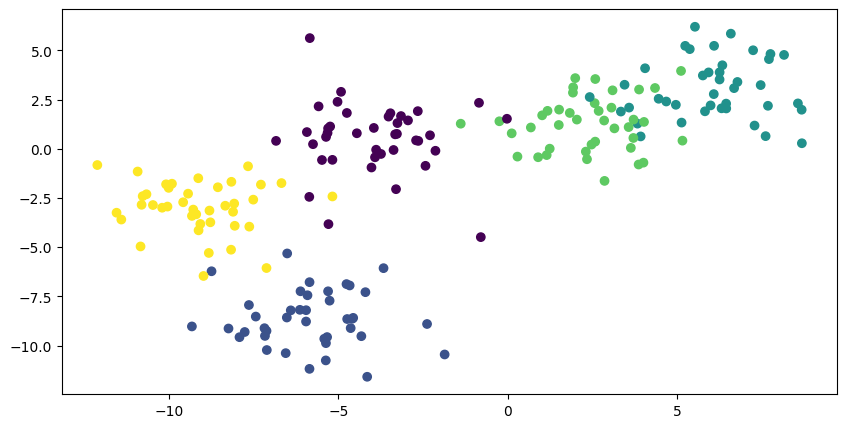

In [3]:
from sklearn.datasets import make_blobs

np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

Dx, Dy = make_blobs(200, 2, centers=5, cluster_std=1.5)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

# 🎯 **1:Cree el Algoritmo de Clustering Mean Shift**

## Calcular el Kernel Gausiano


In [4]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

El algoritmo MeanShift usa la función kernel para delimitar el vecindario y devolver el peso de cada instancia del vecindario

In [5]:
def kernel_gaussiano(mDistancia, i, h):
    dist = mDistancia[i, :]
    # Kernel gaussiano
    weights = np.exp(-(dist/h)**2) # p1. Complete el codigo
    # Solo se aceptan los que estén en el vecindario (bandwidth efectivo)
    weights[weights <= (1.0 / np.e)] = 0
    return weights

Complete la función que calcula el vector shift y el centro de masa ponderado

In [6]:
def mean_shift_vector(X, weights, i):
    # Asegurar que weights tenga la forma correcta
    weights = weights.reshape(-1, 1)
    # Calcular centro de masa ponderado
    numerador = np.sum(weights * X, axis=0) # p2. Complete el codigo
    denominador = np.sum(weights) # p3. Complete el codigo
    if denominador > 0:
        centro_masa_ponderado = numerador / denominador
        shift = centro_masa_ponderado - X[i, :]
        return centro_masa_ponderado, shift
    else:
        return X[i, :], np.zeros_like(X[i, :])

Ahora cree el algoritmo mean shift iterativo

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=100, tolerancia=1e-5):
    actDx = np.copy(Dx)
    n_muestras = actDx.shape[0]

    # Historial de trayectorias para graficar (opcional)
    trayectorias = np.zeros((n_iteraciones, n_muestras, actDx.shape[1]))

    for iteracion in range(n_iteraciones):
        actDx_anterior = np.copy(actDx)
        mDistancia = matriz_distancias(actDx, distancia_euclidiana)
        for i in range(n_muestras):
            # Calcular pesos usando kernel gaussiano
            weights = kernel_gaussiano(mDistancia, i, h) # p4. Complete el codigo
            # Calcular nuevo centro de masa
            nuevo_punto, shift = mean_shift_vector(actDx, weights, i) # p5. Complete el codigo
            actDx[i, :] = nuevo_punto
        # Guardar trayectoria (opcional)
        trayectorias[iteracion, :, :] = actDx
        # Verificar convergencia
        desplazamiento_total = np.sum(np.sqrt(np.sum((actDx - actDx_anterior)**2, axis=1))) # p6. Complete el codigo
        if iteracion % 3 == 0:
            print(f"Iteración {iteracion}: Desplazamiento medio = {desplazamiento_total:.6f}")

        if desplazamiento_total < tolerancia:
            print(f"Convergencia alcanzada en iteración {iteracion}")
            trayectorias = trayectorias[:iteracion+1, :, :]
            break

    centros = np.unique(np.round(actDx ,3), axis=0)
    asignacion = np.argmin(euclidean_distances(actDx, centros), axis=1) # p7. Complete el codigo
    return np.array(centros), asignacion, trayectorias[:iteracion+1, :, :]

Esta función permite vizuaizar la asignacion de los puntos a los clusters y la trayectoria de algunos puntos desde su posicion inicial al centro del cluster

In [8]:
def visualizar_proceso_mean_shift(X, h, centroides, etiquetas, trayectorias=None):
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Gráfico 1: Datos originales y clusters finales
        axes[0].scatter(X[:, 0], X[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, s=50)
        axes[0].scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=100, label='Centroides')
        axes[0].set_title(f'Resultado Mean Shift (h={h})')
        axes[0].set_xlabel('Feature 1')
        axes[0].set_ylabel('Feature 2')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Gráfico 2: Trayectorias de los puntos (si está disponible)
        if trayectorias is not None and trayectorias.shape[0] > 1:
            for i in range(min(50, X.shape[0])):  # Mostrar solo algunos puntos
                axes[1].plot(trayectorias[:, i, 0], trayectorias[:, i, 1],
                           alpha=0.5, linewidth=1)
            axes[1].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=30, label='Inicio')
            axes[1].scatter(centroides[:, 0], centroides[:, 1], c='red',
                          marker='X', s=200, label='Final')
            axes[1].set_title('Trayectorias de convergencia')
            axes[1].set_xlabel('Feature 1')
            axes[1].set_ylabel('Feature 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib no está instalado. Instala con: pip install matplotlib")


## Ahora ya estamos en disposición de realizar el Mean Shift.


In [9]:
 # Aplicar Mean Shift
h = 4.0  # Bandwidth
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)

print(f"\nNúmero de clusters encontrados: {len(centroides)}")
print(f"Centroides: {centroides}")


Iteración 0: Desplazamiento medio = 233.008877
Iteración 3: Desplazamiento medio = 26.573911
Iteración 6: Desplazamiento medio = 84.542149
Iteración 9: Desplazamiento medio = 3.784069
Iteración 12: Desplazamiento medio = 0.007179
Iteración 15: Desplazamiento medio = 0.000015
Convergencia alcanzada en iteración 16

Número de clusters encontrados: 3
Centroides: [[-7.049 -5.414]
 [-4.287 -0.27 ]
 [ 3.838  2.127]]


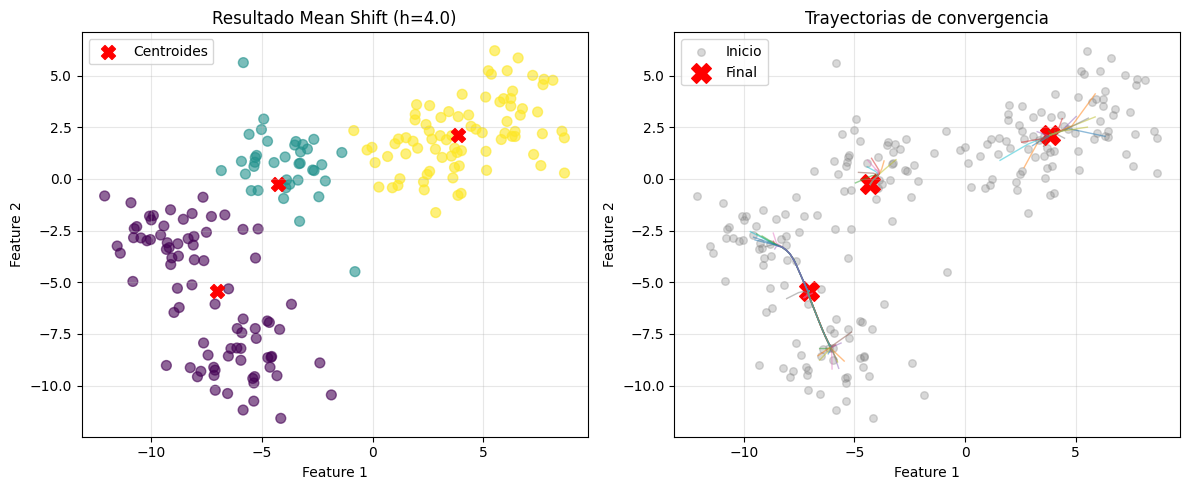

In [10]:
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

<hr>
Podemos jugar con diferentes valores de $\epsilon$ y $M$ para ver su efecto sobre diferentes conjuntos de datos:


In [11]:
D1 =cargar_dataset("dataset_dos_remolinos.xlsx")
D1 = D1[ np.random.choice(np.arange(D1.shape[0]), D1.shape[0], replace=False) ,:]
Dx1 = D1[:,1:3]
Dy1 = D1[:,3]

✅ Dataset cargado desde URL GitHub


Iteración 0: Desplazamiento medio = 16.699666
Iteración 3: Desplazamiento medio = 13.403507
Iteración 6: Desplazamiento medio = 2.034881
Iteración 9: Desplazamiento medio = 0.005773
Iteración 12: Desplazamiento medio = 0.000012
Convergencia alcanzada en iteración 13

Número de clusters encontrados: 21


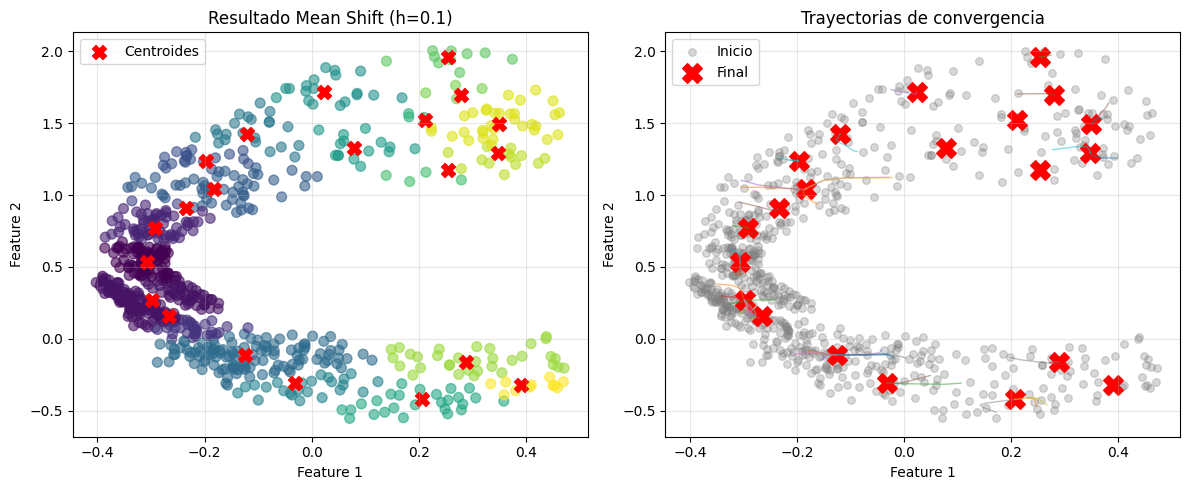

In [15]:
 # Aplicar Mean Shift
h = 0.1
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx1, h, n_iteraciones=50) # p8. Complete el codigo
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx1, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 37.124688
Iteración 3: Desplazamiento medio = 19.099865
Iteración 6: Desplazamiento medio = 0.808507
Iteración 9: Desplazamiento medio = 0.014544
Iteración 12: Desplazamiento medio = 0.000027
Convergencia alcanzada en iteración 13

Número de clusters encontrados: 8


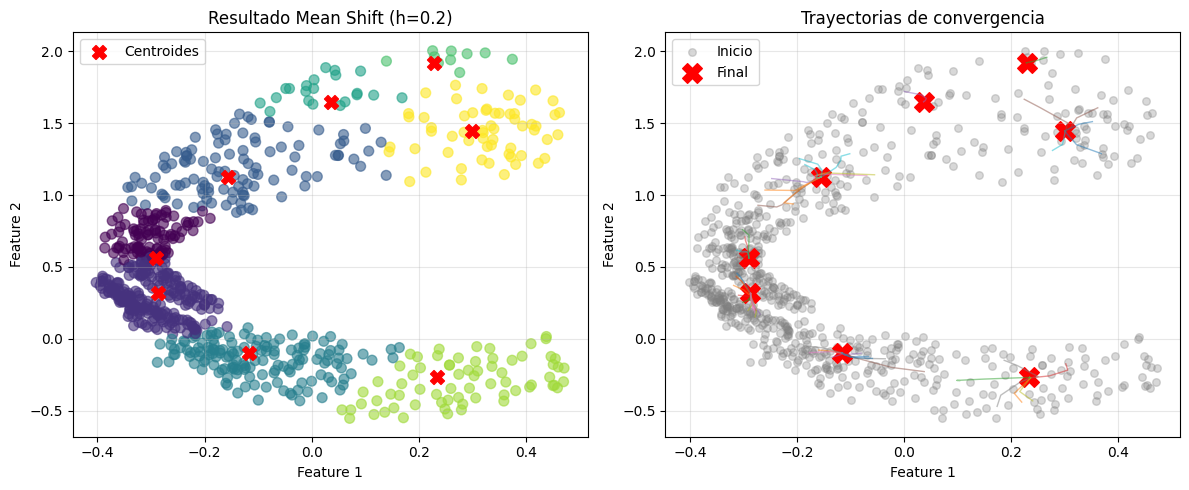

In [14]:
 # Aplicar Mean Shift
h = 0.2
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx1, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx1, h, centroides, etiquetas, trayectorias)
# p9. Complete el codigo

Iteración 0: Desplazamiento medio = 103.297659
Iteración 3: Desplazamiento medio = 31.835258
Iteración 6: Desplazamiento medio = 0.051408
Iteración 9: Desplazamiento medio = 0.000095
Convergencia alcanzada en iteración 11

Número de clusters encontrados: 2


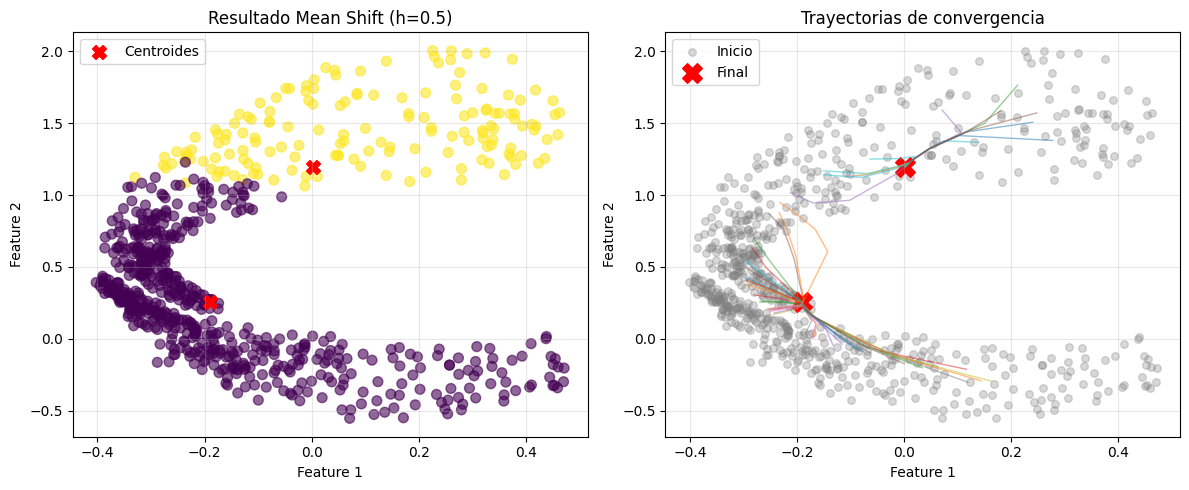

In [16]:
 # Aplicar Mean Shift
h = 0.5
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx1, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx1, h, centroides, etiquetas, trayectorias)
# p10. Complete el codigo

## Definir el rango de experimentación de h

Complete el calculo de los metodos para definir h

In [25]:
def calcular_h_automatico(X, metodo='silverman', dimension=None):
    n_muestras, n_caracteristicas = X.shape
    if metodo == 'silverman':
        # Regla de Silverman para múltiples dimensiones
        # h = σ * n^{-1/(d+4)}
        if dimension is None:
            # Usar promedio de desviaciones estándar
            sigma = np.mean(np.std(X, axis=0))
            d_param = n_caracteristicas #Aumentado porque sino dimension == None no puede sumar +4
        else:
            sigma = np.std(X[:, dimension])
            d_param = 1 #Aumentado porque sino dimension == None no puede sumar +4
        h  = sigma * n_muestras**(-1/(d_param+4)) # p11. Complete el codigo
        info = {
            'metodo': 'Regla de Silverman',
            'sigma': sigma,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas,
            'formula': 'h = σ * n^{-1/(d+4)}'
        }
    elif metodo == 'scott':
        # Regla de Scott: h = σ * n^{-1/(d+4)}
        # Similar a Silverman pero con factor diferente
        if dimension is None:
            sigma = np.mean(np.std(X, axis=0))
            d_param = n_caracteristicas
        else:
            sigma = np.std(X[:, dimension])
            d_param = 1
        # Factor de Scott: 1.06
        factor = 1.06
        h = sigma * n_muestras**(-1/(d_param+4)) * factor # p12. Complete el codigo
        info = {
            'metodo': 'Regla de Scott',
            'sigma': sigma,
            'factor': factor,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas
        }

    elif metodo == 'rango':
        # Porcentaje del rango total de datos
        rangos = np.ptp(X, axis=0)  # peak-to-peak (máx - mín)
        rango_promedio = np.mean(rangos)
        # Usar 15% del rango como punto de partida
        porcentaje = 0.15
        h  = rango_promedio * porcentaje # p13. Complete el codigo

        info = {
            'metodo': 'Porcentaje del rango',
            'rango_promedio': rango_promedio,
            'porcentaje': porcentaje,
            'rangos_individuales': rangos.tolist()
        }

    elif metodo == 'std':
        # Fracción de la desviación estándar
        stds = np.std(X, axis=0)
        std_promedio = np.mean(stds)

        # Usar 1/3 de la desviación estándar
        fraccion = 0.33
        h = std_promedio * fraccion # p14. Complete el codigo

        info = {
            'metodo': 'Fracción de desviación estándar',
            'std_promedio': std_promedio,
            'fraccion': fraccion,
            'stds_individuales': stds.tolist()
        }

    else:
        raise ValueError(f"Método '{metodo}' no reconocido. Usar: 'silverman', 'scott', 'rango', 'std'")
    return h, info

Experimente con el dataset

In [26]:
D2 =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D2 = D2[ np.random.choice(np.arange(D2.shape[0]), D2.shape[0], replace=False) ,:]
Dx2 = D2[:,1:3]
Dy2 = D2[:,3]

✅ Dataset cargado desde URL GitHub


In [35]:
# Métodos a evaluar
metodos = ['silverman', 'scott', 'rango', 'std']

print("\n" + "="*70)
print("CÁLCULO DE BANDWIDTH (h) CON DIFERENTES MÉTODOS")
print("="*70)
# Calcular h para cada método
resultados_h = {} #Aumentado para usar el h exacto a continuación
for metodo in metodos:
    h_base, info = calcular_h_automatico(Dx2, metodo)
    resultados_h[metodo] = h_base #Aumentado para usar el h exacto a continuación
    print(f"\nMétodo: {metodo.upper()}")
    print(f"  h calculado: {h_base:.6f}")

    # Información adicional específica por método
    if 'sigma' in info:
        print(f"  Sigma usado: {info['sigma']:.6f}")
    if 'rango_promedio' in info:
        print(f"  Rango promedio: {info['rango_promedio']:.6f}")
    if 'std_promedio' in info:
        print(f"  Std promedio: {info['std_promedio']:.6f}")



CÁLCULO DE BANDWIDTH (h) CON DIFERENTES MÉTODOS

Método: SILVERMAN
  h calculado: 0.069085
  Sigma usado: 0.245201

Método: SCOTT
  h calculado: 0.073231
  Sigma usado: 0.245201

Método: RANGO
  h calculado: 0.147554
  Rango promedio: 0.983692

Método: STD
  h calculado: 0.080916
  Std promedio: 0.245201


Experimentar con los valores de h, desde el valor minimo al maximo, incrementando de poco a poco y graficando los resultados del agrupamiento.

Iteración 0: Desplazamiento medio = 29.641183
Iteración 3: Desplazamiento medio = 30.302961
Iteración 6: Desplazamiento medio = 10.223092
Iteración 9: Desplazamiento medio = 0.329872
Iteración 12: Desplazamiento medio = 2.721057
Iteración 15: Desplazamiento medio = 0.008349
Iteración 18: Desplazamiento medio = 0.000015
Convergencia alcanzada en iteración 19

Número de clusters encontrados: 13


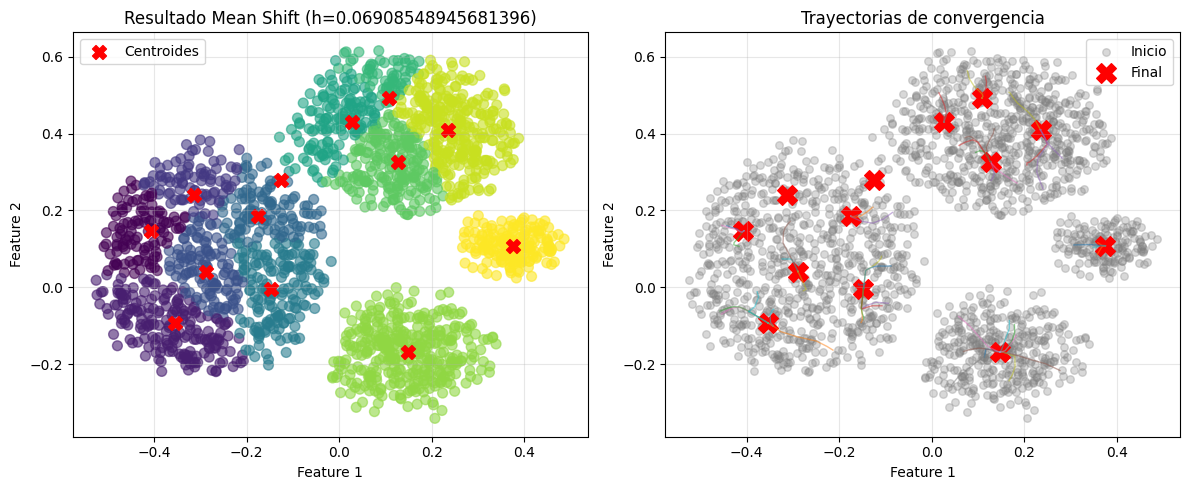

In [36]:
# p15. Complete el codigo
h = resultados_h['silverman']
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx2, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx2, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 32.156392
Iteración 3: Desplazamiento medio = 33.014172
Iteración 6: Desplazamiento medio = 4.523105
Iteración 9: Desplazamiento medio = 0.328341
Iteración 12: Desplazamiento medio = 0.000279
Convergencia alcanzada en iteración 14

Número de clusters encontrados: 12


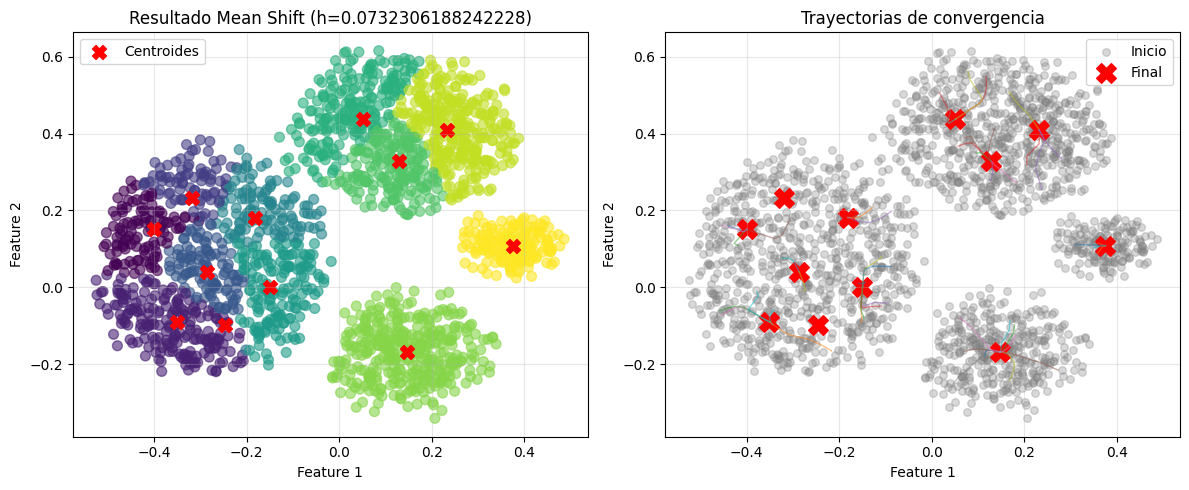

In [37]:
h = resultados_h['scott']
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx2, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx2, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 37.158115
Iteración 3: Desplazamiento medio = 34.081065
Iteración 6: Desplazamiento medio = 8.108730
Iteración 9: Desplazamiento medio = 0.992332
Iteración 12: Desplazamiento medio = 0.960127
Iteración 15: Desplazamiento medio = 0.925181
Iteración 18: Desplazamiento medio = 0.842918
Iteración 21: Desplazamiento medio = 0.018191
Iteración 24: Desplazamiento medio = 0.000029
Convergencia alcanzada en iteración 25

Número de clusters encontrados: 9


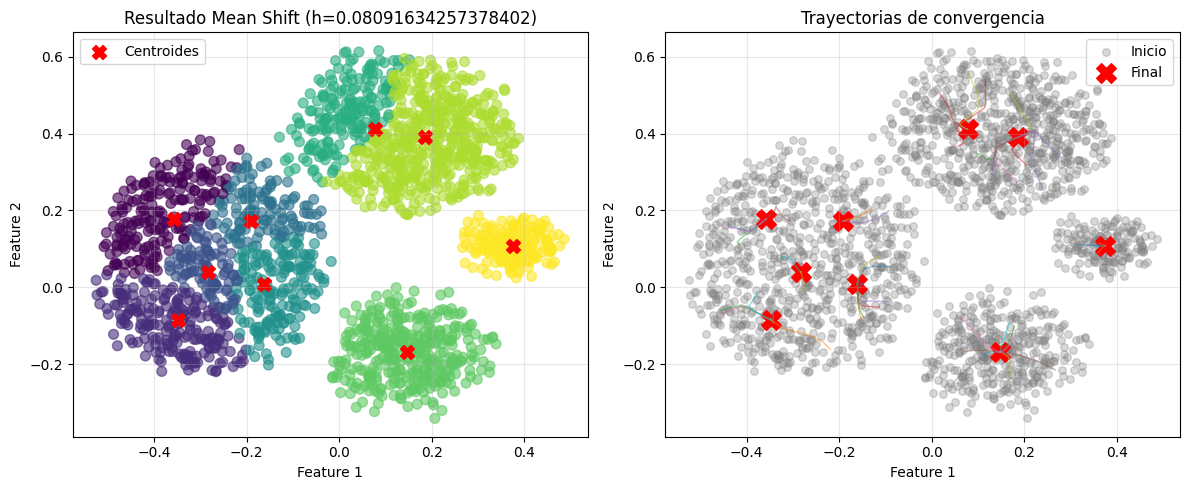

In [38]:
h = resultados_h['std']
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx2, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx2, h, centroides, etiquetas, trayectorias)

In [ ]:
h = resultados_h['rango']
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx2, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx2, h, centroides, etiquetas, trayectorias)
#No está dibujado por falta de tiempo

<hr>
<h2>Implementaciones en librerías de Python</h2>

Scikit-learn (scikit-learn) es la implementación más popular y ampliamente utilizada:

In [39]:
from sklearn.cluster import MeanShift

# Uso básico
ms = MeanShift(bandwidth=0.5)
ms.fit(Dx)

# Obtener resultados
etiquetas = ms.labels_
centros = ms.cluster_centers_

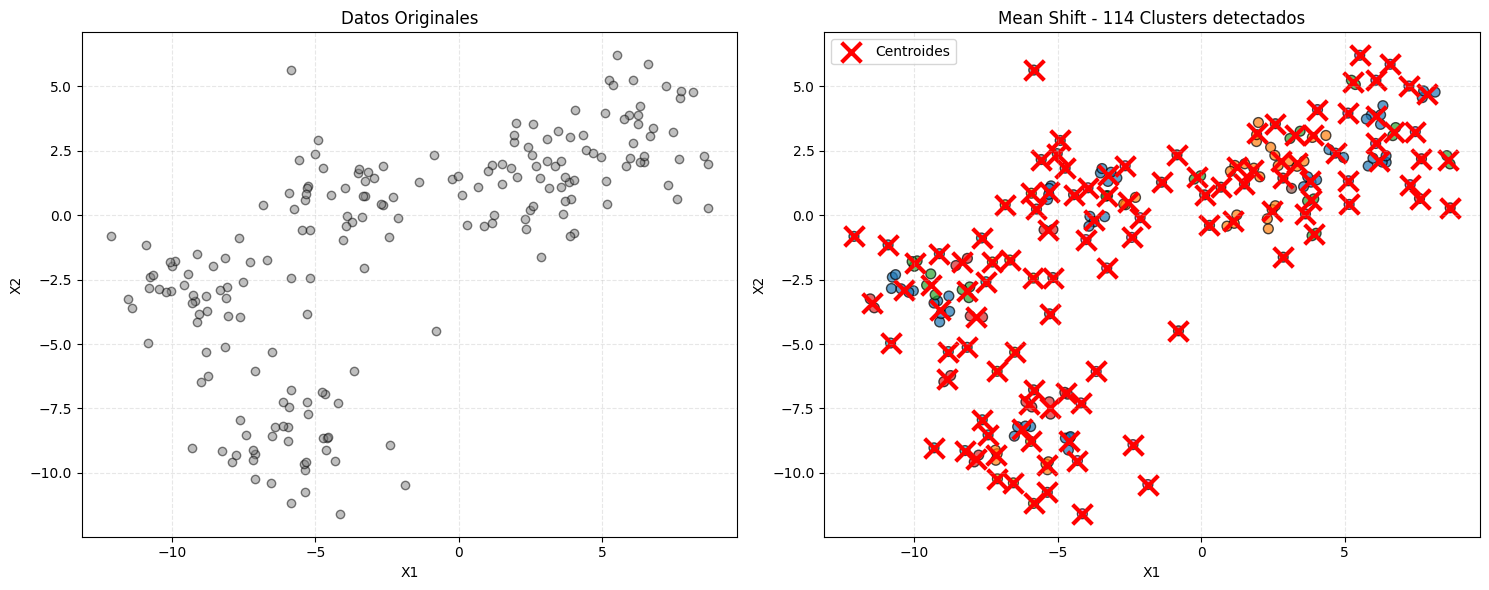

In [41]:
 # GRAFICAR LOS GRUPOS
# P16 SU CODIGO AQUI
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(Dx[:, 0], Dx[:, 1], c='gray', alpha=0.5, edgecolor='k')
axs[0].set_title("Datos Originales")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].grid(True, linestyle='--', alpha=0.3)

scatter = axs[1].scatter(Dx[:, 0], Dx[:, 1], c=etiquetas, cmap='tab10', s=50, alpha=0.7, edgecolor='k')

axs[1].scatter(centros[:, 0], centros[:, 1],
               marker='x',
               s=200,
               linewidths=3,
               color='red',
               label='Centroides')

n_clusters = len(centros)
axs[1].set_title(f"Mean Shift - {n_clusters} Clusters detectados")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

#No se uso el visualizar porqueno se apreciaba bien el gráfico.

# 🚀 ¡TALLER FINALIZADO!"